In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '../')
from scipy.optimize import minimize
from scipy.stats import beta
import util.util as util
from util.util import evaluate,SAA_minimise
from scipy.stats import wasserstein_distance

In [144]:
# beta distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)

In [145]:
def wasserstein_constraint(limit,samples,delta):
    distance =np.mean(np.concatenate((limit[0] - samples[limit[0] > samples],
               samples[limit[1] < samples] - limit[1])))
    return  delta-distance

In [146]:
def limit_constraint(limit):
    # right hand side must be greater than lefthand side
    return limit[1]-limit[0]

In [147]:
def plot_sample_change(x_star,Sy,new_y,func):
    
    # get a plot of the cost function
    temp_y = np.linspace(np.min(Sy),np.max(Sy),500)
    full_cost = evaluate(x_star,temp_y,func,find_mean=False)
    
    # get cost of samples
    sub_cost = evaluate(x_star,Sy,func,find_mean=False)
    # cost of changed samples
    altered = evaluate(x_star,new_y,func,find_mean=False)
    
    # check which samples have changed
    changed_index = np.isclose(Sy,new_y,atol=1e-2) == False
    
    changed_samples = new_y[changed_index]
    changed_cost = evaluate(x_star,changed_samples,func,find_mean=False)
    original_samples = Sy[changed_index]
    original_cost = sub_cost[changed_index]
    
    # plot the hraph
    plt.figure(figsize=(10,8))
    plt.plot(temp_y,full_cost,label='cost function')
    plt.plot(Sy,sub_cost,'o',label='samples')

    plt.plot(changed_samples,original_cost,'o',label='altered samples')
    for i in range(len(changed_cost)):
        plt.arrow(original_samples[i],
                  original_cost[i],
                  (changed_samples[i]-original_samples[i])*0.7,
                  0,head_width=0.02,length_includes_head=False)
    plt.legend()

In [148]:
def test(limit,x_star,samples,func):
    #new_Sy = np.copy(samples)
    #new_Sy[:np.searchsorted(sort_Sy,limit[0],'right')] = limit[0]
    #new_Sy[np.searchsorted(sort_Sy,limit[1],'left'):] = limit[1]
    
    new_Sy = alter_samples(limit,samples)
    return -evaluate(x_star,new_Sy,func)

In [149]:
def alter_samples(limit,samples):
    new_samples = np.copy(samples)
    new_samples[:np.searchsorted(samples,limit[0],'right')] = limit[0]
    new_samples[np.searchsorted(samples,limit[1],'left'):] = limit[1]
    
    return new_samples

In [155]:
def wasserstein_robustification(samples,x_star,func):
    
    constraint = [{'type':'ineq','fun':wasserstein_constraint,'args':[samples,delta]},
             {'type':'ineq','fun':limit_constraint}]
    bound = [(-1,1)]*2
    
    limit = [samples[1],samples[-2]]
    res = minimize(test,limit,args=(x_star,samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 500,
                          'ftol': 1e-06})
    new_samples = alter_samples(res.x,samples)
    return new_samples

In [157]:
new_sample = wasserstein_robustification(sort_Sy,x_star,util.f1)

In [158]:
wasserstein_distance(np.sort(Sy),new_sample)

0.01728934547691227

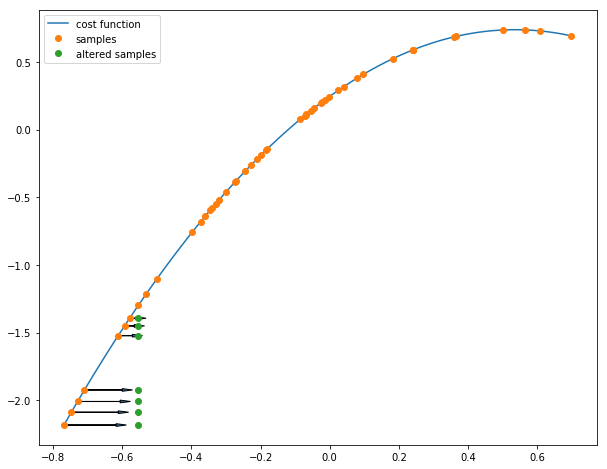

In [159]:
plot_sample_change(x_star,np.sort(Sy),new_sample,util.f1)

In [522]:
def wasserstein_constraint_convex(variables,bounds,samples,delta):
    """
    in convex functions, the limit is fixed,
    what we try to do is determine the number of samples to move
    to that limit and the fraction of movement
    
    variables[0] and variables[1] is the index, left and right respectively
    variables[2] and variables[3] are weights, elft and right respectively
    """
    left = samples[:int(variables[0])+1] - bounds[0]
    # the last element is "fractionally" moved
    left[-1] *= variables[2]
    
    # do the same for the right side
    right =  samples[int(variables[1])+1:] - bounds[1]

    right[0] *= variables[3]
    
    if right.shape[0] == 1 and left.shape[0] == 1:
        distance = 0.0
    else:
        distance =np.mean(np.concatenate((right[:-1], left[1:])))
    return delta-distance

In [523]:
def alter_samples_convex(index,limit,samples):
    new_samples = np.copy(samples)
    
    # move left side samples to the left limit
    new_samples[:int(index[0])] = limit[0]
    #new_samples = np.insert(new_samples,int(index[0]),limit[0])
    
    # similarly for the right
    new_samples[int(index[1])+1:] = limit[1]
    #new_samples = np.insert(new_samples,int(index[1])+2,limit[1])
    return new_samples

In [524]:
def test_convex(variables,limit,x_star,samples,func):
    # just remember we have samples = [bound_neg, x0,x1,x2,...,xn,bound_pos]
    # assign the weights
    weights = np.ones((samples.shape[0]))
    # at the lefthand side, thr weight is a fraction of one
    weights[0] = variables[2]
    weights[int(variables[0])] = 1 - variables[2]
    
    weights[-1] = variables[3]
    weights[int(variables[1]+1)] = 1 - variables[3]
    
    new_S = alter_samples_convex(variables[:2],limit,samples)
    return -evaluate(x_star,new_S,func,weights=weights)

In [557]:
def wasser_robustification_convex(samples,sample_bounds,x_star,func):
    # sort the samples
    samples = np.sort(samples)
    # added limits for computations
    added_samples = np.insert(samples,[0,samples.shape[0]],[-1.0,1.0])
    
    # constraints and bounds
    constraint = [{'type':'eq','fun':wasserstein_constraint_convex,
                   'args':[sample_bounds,added_samples,delta]},
             {'type':'ineq','fun':limit_constraint},
            {'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(2)])}]
    bound = [(0,samples.shape[0]),(0,samples.shape[0]),(0,1),(0,1)]
    
    # initial guess
    # index 0, shape+1 means no movement,
    initial_variable = [1,15,0.5,0.5]
    
    
    
    res = minimize(test_convex,initial_variable,args=(sample_bounds,x_star,added_samples,func),
                   constraints=constraint,bounds=bound,
                  options={'maxiter': 1000,
                          'ftol': 1e-06})
    new_samples = alter_samples_convex(res.x,sample_bounds,added_samples)
    return new_samples,res.x

In [558]:
Sy = Y.rvs(50)
sort_Sy = np.sort(Sy)

In [584]:
delta = 2.0
x_star = SAA_minimise(sort_Sy,util.f2)

In [585]:
sample_bounds = [-1,1]
new_sample,var = wasser_robustification_convex(sort_Sy,sample_bounds,x_star,util.f2)

In [586]:
new_sample

array([-1.        , -0.80715502, -0.73483356, -0.68666797, -0.52425491,
       -0.47797873, -0.44073606, -0.4212841 , -0.41406998, -0.39870632,
       -0.39138943, -0.35957647, -0.28974083, -0.24588815, -0.23557281,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

In [587]:
var

array([ 1., 15.,  1.,  0.])

In [588]:
wasserstein_constraint_convex(var,sample_bounds,new_sample,0.1)

0.09478797340286685